# Background tests for data formatting

## floating point error
Can we use 16-bit floats to represent waveform data with acceptable accuracy?

/var/folders/4c/2cryg6ld5b10g45f5cpsrf740016fl/T/ipykernel_42538/3277665977.py:18: RuntimeWarning: overflow encountered in cast
  x_uint = x.astype(as_dtype).view(uint_type)


(-150.0, 286.0)

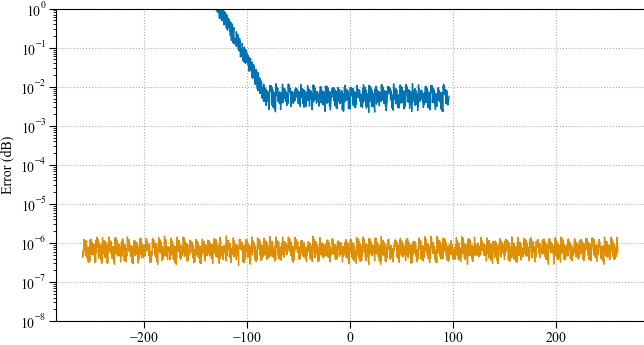

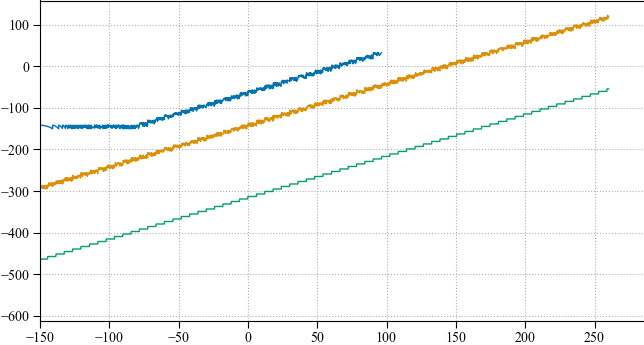

In [110]:
from __future__ import annotations
import numpy as np
from matplotlib import pyplot as plt
import iqwaveform
plt.style.use('iqwaveform.nist_report')

def bitwise_step(x: np.array[np.float16 | np.float32], as_dtype=np.float16):
    as_dtype = np.dtype(as_dtype)
    if as_dtype == np.dtype('float16'):
        uint_type = np.dtype('uint16')
    elif as_dtype == np.dtype('float32'):
        uint_type = np.dtype('uint32')
    elif as_dtype == np.dtype('float64'):
        uint_type = np.dtype('uint64')
    else:
        raise TypeError('unrecognized type ', as_dtype)

    x_uint = x.astype(as_dtype).view(uint_type)
    return (x_uint + uint_type.type(1)).view(as_dtype).astype(np.float64) - x.astype(
        np.float64
    )


x = np.logspace(-13, 13, 26 * 100 + 1, dtype=np.float64)
err16 = bitwise_step(x, np.float16)
err32 = bitwise_step(x, np.float32)
err64 = bitwise_step(x, np.float64)

fig, ax = plt.subplots()
for name, err in (('float16', err16), ('float32', err32), ('float64', err64)):
    ax.plot(20 * np.log10(x), 20 * np.log10((x + err) / x), label=name)
# plt.xlim([-150,None])
ax.set_ylim([1e-8, 1])
ax.set_yscale('log')
ax.set_ylabel('Error (dB)')

fig, ax = plt.subplots()
for name, err in (('float16', err16), ('float32', err32), ('float64', err64)):
    ax.plot(20 * np.log10(x), 20 * np.log10(err), label=name)
ax.set_xlim([-150, None])

### Frequency-domain impacts of floating point quantization noise
A comparison of half- and single-precision accuracy impacts evaluated by downcasting from `float64`/`complex128`.

The choice of evaluation relative to _total_ (integrated) quantization noise power in this characterization was made because it is very close to invariant with NFFT and the choice of windowing function. Density can be evaluated by scaling this quantity relative to a desired noise bandwidth.

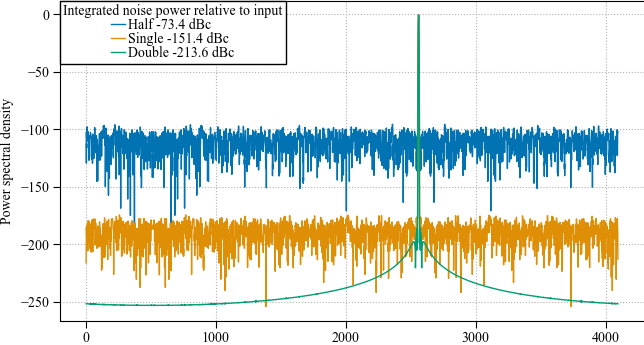

In [111]:
import scipy

def est_total_noise_db(y, side='left'):
    y = y/np.sqrt(np.sum(np.abs(y)**2))
    if side == 'left':
        sel = y[:y.size//2]
    elif side == 'right':
        sel = y[y.size//2:]
    return 10*np.log10(2*np.sum(np.abs(sel)**2))

fs = 1e6
fc = 0.125e6
t = np.arange(4096, dtype='float64') / fs

mag = 1e-2
x = mag*np.exp(2j * np.pi * fc * t+np.pi/2).astype('complex128') / np.sqrt(2)
x *= scipy.signal.get_window(('dpss', 7), x.size)

x16 = x.view('float64').astype('float16').astype('float64').view('complex128')
x32 = x.view('float64').astype('float32').astype('float64').view('complex128')

X = scipy.fft.fftshift(scipy.fft.fft(x)) / x.size / mag
X16 = scipy.fft.fftshift(scipy.fft.fft(x16)) / x.size / mag
X32 = scipy.fft.fftshift(scipy.fft.fft(x32)) / x.size / mag

fig, ax = plt.subplots()
ax.plot(20 * np.log10(np.abs(X16)), label=f'Half {est_total_noise_db(X16):0.1f} dBc')
ax.plot(20 * np.log10(np.abs(X32)), label=f'Single {est_total_noise_db(X32):0.1f} dBc')
ax.plot(20 * np.log10(np.abs(X)), label=f'Double {est_total_noise_db(X):0.1f} dBc')
ax.legend(title='Integrated noise power relative to input')
plt.ylabel('Power spectral density');

What about float16 (mag, phase)?

In [112]:
import scipy
import numcodecs
import numcodecs.zfpy

compressors = {
    tol: numcodecs.zfpy.ZFPY(tolerance=tol)
    for tol in (1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2)
}

fs = 1e3
fc = 0.2e3
t = np.arange(int(1e5), dtype='float64') / fs
x = np.exp(2j * np.pi * fc * t + np.pi / 2).astype('complex128') / np.sqrt(2)
x *= scipy.signal.get_window(('dpss', 8), x.size)

fig, ax = plt.subplots()

xrecov = {}
Xrecov = {}
for tol, comp in list(compressors.items())[::-1]:
    xrecov[tol] = (
        comp.decode(comp.encode(x.view('float64').astype('float32')))
        .astype('float64')
        .view('complex128')
    )
    Xrecov[tol] = scipy.fft.fftshift(scipy.fft.fft(xrecov[tol])) / x.size
    ax.plot(20 * np.log10(np.abs(Xrecov[tol])), label=tol)

ax.legend(title='ZFPY tolerance')
# ax.set_ylim([1e-8,1])
# ax.set_yscale('log')
# ax.set_ylabel('Error (dB)')

# fig, ax = plt.subplots()
# for name, err in (('float16', err16), ('float32', err32)):
#     ax.plot(20*np.log10(x), 20*np.log10(err), label=name)
# ax.set_xlim([-150,None])

AttributeError: module 'numcodecs.zfpy' has no attribute 'ZFPY'